In [37]:
import pickle
from random import sample
# PB: prediction based algorithm
# RB: response based algoritm


file_name_PB = "data/vision_forward_graph_data_08_09_22.pkl"
with open(file_name_PB, 'rb') as f:
    df_PB = pickle.load(f)
    #df_PB.sort_values(by="platform", inplace=True, ignore_index=True)

file_name_RB = "data/vision_graph_data_remote_23_08_22.pkl"
with open(file_name_RB, 'rb') as f:
    df_RB = pickle.load(f)


file_name_baseline = "data/vision_baseline_graph_data_24_08_22.pkl"
with open(file_name_RB, 'rb') as f:
    df_baseline = pickle.load(f)

file_name_centrality = "data/author_centrality_remote.pkl"
with open(file_name_centrality, 'rb') as f:
    df_centrality = pickle.load(f)

common_conversation_ids = set(df_PB.conversation_id).intersection(df_RB.conversation_id).intersection(
    df_centrality.conversation_id).intersection(df_baseline.conversation_id)
all_conversation_ids = set(df_PB.conversation_id).union(df_RB.conversation_id).union(df_centrality.conversation_id).union(df_baseline.conversation_id)
all_conversation_count = len(all_conversation_ids)
common_conversation_count = len(common_conversation_ids)
# reducing the sample size for testing
common_conversation_ids = sample(common_conversation_ids, 50)

print("From {} conversations {} are shared in all datasets".format(all_conversation_count, common_conversation_count))


df_PB = df_PB[df_PB.conversation_id.isin(common_conversation_ids)]
df_RB = df_RB[df_RB.conversation_id.isin(common_conversation_ids)]
df_centrality = df_centrality[df_centrality.conversation_id.isin(common_conversation_ids)]
df_baseline = df_baseline[df_baseline.conversation_id.isin(common_conversation_ids)]
df_PB.shape

From 4627 conversations 1292 are shared in all datasets


(36744, 127)

### Utility Functions

The following cell contains utility functions that are needed for all the different algorithms

In [38]:

from random import sample


def is_not_reddit_or_twitter(text):
    if text == "reddit" or text == "twitter":
        return False
    else:
        return True


def equalize_samples(df):
    """
    this approximates the same number of conversations for both platforms
    :param df:
    :return:
    """
    df_conversations_twitter = set(df[df["platform"] == "twitter"].conversation_id.tolist())
    df_conversations_reddit = set(df[df["platform"] == "reddit"].conversation_id.tolist())
    reddit_data_count = df.loc[df.platform == "reddit", 'platform'].count()
    twitter_data_count = df.loc[df.platform == "twitter", 'platform'].count()
    # assert twitter_data_count > reddit_data_count, "counts (reddit, twitter) are ({},{}):".format(reddit_data_count, twitter_data_count)
    current_count = 0
    n = 1
    smaller_count = reddit_data_count
    df_conversations = df_conversations_twitter
    if reddit_data_count > twitter_data_count:
        smaller_count = twitter_data_count
        df_conversations = df_conversations_reddit
    while current_count < smaller_count:
        chosen_conversation_ids = sample(df_conversations, n)
        df_candidate = df[df["conversation_id"].isin(chosen_conversation_ids)]
        n = n + 1
        current_count = df_candidate.shape[0]
    print("chosen {} conversations and gotten {} from twitter compared to {} from reddit".format(n, current_count,
                                                                                                 reddit_data_count))
    not_chosen_conversation_ids = set(df_conversations) - set(chosen_conversation_ids)
    df_result = df[~df["conversation_id"].isin(not_chosen_conversation_ids)]
    return df_result


### Non-Features

All the cells contain a number of columns that have a meaning in the conversation but are not features to train the NN with.

In [39]:

# some utility functions to take the columns that are used as features
non_feature_list = ["current", "beam_node", "conversation_id", "platform", "has_followed_path", "has_follow_path",
                    "beam_node_author", "author"]


def take_features(df, additional_non_features=[]):
    non_feature_list2 = non_feature_list + additional_non_features
    df = df.drop(non_feature_list2, axis=1)
    return df


def take_non_features(df, additional_non_features=[]):
    non_feature_list2 = non_feature_list + additional_non_features
    column_names = df.columns.values
    feature_list = [column_name for column_name in column_names if column_name not in non_feature_list2]
    df = df.drop(feature_list, axis=1)
    return df


def normalize_timedelta(df):
    # normalize timedelta (put between 0 and 1)
    dt = df.timedelta
    timedelta_normalized = (dt - dt.min()) / (dt.max() - dt.min())
    df = df.assign(timedelta=timedelta_normalized)
    return df



#### Data Cleaning and Data preperation
- Delete rows that are neither twitter or reddit data
- normalize time deltas


In [40]:
# filtering data that is not twitter or reddit
def delete_not_twitter_not_reddit(df):
    platform = df.platform
    to_delete_rows = platform.apply(lambda x: is_not_reddit_or_twitter(x))
    df = df.drop(df[to_delete_rows].index)
    return df

df_RB = delete_not_twitter_not_reddit(df_RB)
df_PB = delete_not_twitter_not_reddit(df_PB)
df_centrality = delete_not_twitter_not_reddit(df_centrality)

df_RB = equalize_samples(df_RB)
df_PB = df_PB[df_PB.conversation_id.isin(df_RB.conversation_id)]
df_centrality = df_centrality[df_centrality.conversation_id.isin(df_RB.conversation_id)]
df_baseline  = df_baseline[df_baseline.conversation_id.isin(df_RB.conversation_id)]

df_RB = normalize_timedelta(df_RB)
df_PB = normalize_timedelta(df_PB)


chosen 32 conversations and gotten 17537 from twitter compared to 20522 from reddit


# Baseline for Author vision
- uses selected values as a distance measure
- probability of having seen a tweet is reduced by a half with each step in the reply hierachy
- probability of having seen a tweet is reduced by a quarter for each step away from the root
- probabiliy of having seen a tweet is increased for each path in the follower network to the tweet (forthcoming)


In [41]:
# in order to allow the comparison, the filter from the other notebook needs to run and the predictions, too
reply_filter_col = [col for col in df_baseline if col.startswith('reply')]
root_distance_filter_col = [col for col in df_baseline if col.startswith('root')]
reply_columns = df_baseline[reply_filter_col]
root_distance_columns = df_baseline[root_distance_filter_col]
reply_cs = reply_columns.sum(axis=1)
root_distance_cs = root_distance_columns.sum(axis=1)
rcs_not_null = [i for i in reply_cs.tolist() if i != 0]
root_reply_combined = (root_distance_cs + reply_cs)
root_reply_combined = (root_reply_combined - root_reply_combined.min()) / (
        root_reply_combined.max() - root_reply_combined.min())
combined = [i for i in root_reply_combined.tolist() if i != 0]
df_baseline = df_baseline.assign(root_reply_combined=root_reply_combined)

In [42]:
df_baseline_with_authors = df_baseline[["root_reply_combined", "conversation_id", "author", "platform"]]
# df_reshaped = pd.pivot_table(df_data,index=["conversation_id", "current"], columns=["root_reply_combined"],aggfunc = np.mean)
baseline_gpm = df_baseline_with_authors.groupby(["platform", "conversation_id", "author"]).mean()
baseline_predictions = baseline_gpm
baseline_predictions.rename(columns={"root_reply_combined": "baseline"},inplace=True)
baseline_predictions

baseline
platform conversation_id     author                       
reddit   2087645             3853842              0.590909
                             21221970             0.631579
                             25043219             0.607143
                             38759243             0.553571
                             87768819             0.545455
...                                                    ...
twitter  1552015261212954624 1418169381545259008  0.375000
                             1430654330932236299  0.295455
                             1440140450434740232  0.300000
                             1450261887208153099  0.354167
                             1513254155393114112  0.333333

[725 rows x 1 columns]

In [43]:
baseline_gpm_conversation = baseline_gpm.groupby(by=["platform", "conversation_id"]).mean()
baseline_gpm = baseline_gpm_conversation.groupby(by=["platform"]).mean()
baseline_gpm


,baseline
platform,
reddit,0.478370
twitter,0.463158


# Repetition Probabilities

#### Analyzing the probability of an author writing repeatedly in the same conversation
1. sum up the amounts y == 1 (because an author has answered himself)
2. sum chances of an author seeing himself write
3. calculate a measure of how likely it is that an author sees himself repeated as a test for the nn

In [44]:
author_count_columns = ["current", "conversation_id", "platform", "y"]
author_df = df_RB[author_count_columns]
author_df = author_df.groupby(["platform", "conversation_id", "current"]).sum()
author_df = author_df.groupby(["platform", "conversation_id"]).mean()
distinct_view_columns = ["current", "conversation_id", "platform"]
distinct_view_df = df_RB[distinct_view_columns]
distinct_views = distinct_view_df.groupby(["current", "conversation_id", "platform"]).size().to_frame('size')
distinct_views = distinct_views.groupby(["platform", "conversation_id"]).mean()
joined_author_stats = author_df.join(distinct_views)
joined_author_stats = joined_author_stats["y"] / joined_author_stats["size"]

# prepare for comparison
import pandas as pd
repetition_predictions = pd.DataFrame(joined_author_stats).rename(columns={0: "repetition"})

joined_author_stats

platform  conversation_id    
reddit    2087645                0.252101
          2258028                0.464286
          3237826                0.147465
          4264097                0.241015
          6879611                0.156863
          13590426               0.384615
          17172485               0.250000
          19161388               0.252941
          20520581               0.144712
          20889898               0.090580
          23330036               0.103333
          31131919               0.363636
          32545716               0.147619
          32854345               0.107692
          34665923               0.266667
          35562400               0.247619
          35824217               0.263158
          42452689               0.116959
          49074540               0.190476
          66271665               0.333333
          67066456               0.143353
          67519271               0.333333
          68536375               0.333333
    

The joined author stats show the repetition probabilities for each of the platforms per conversation.

In [45]:
repetition_probability = joined_author_stats.groupby("platform").mean().to_frame("repetition_probs")
repetition_probability


,repetition_probs
platform,
reddit,0.229362
twitter,0.166380


# The Response Based Author vision Algorithm (RB)

The features are the distance of the author to any tweet in the conversation
indicated by the following structures:
- subtree to viewed tweet from a tweet the author wrote
- root closeness of viewed tweet
- time delta to viewed tweet from tweets the author wrote

#### Loading the data from the pickled version
1. importing libraries
2. checking gpu support


In [46]:
#import modin.pandas as pd
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
print("cuda gpu is available: {}".format(is_cuda_gpu_available))

cuda gpu is available: True


2022-08-25 09:41:50.598702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:41:50.600341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:41:50.600555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:41:50.607028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:41:50.607495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [47]:
# df = df[df["root_distance_0"] == 0]
# analyze the distribution of reached targets for the sample
print("reddit:")
print(df_RB[df_RB["platform"] == "reddit"].y.value_counts())
print("twitter:")
print(df_RB[df_RB["platform"] == "twitter"].y.value_counts())
# this should be higher for reddit as the unique author / posting ratio is lower for reddit

reddit:
0    15228
1     2309
Name: y, dtype: int64
twitter:
0    13246
1     2976
Name: y, dtype: int64


### Computing a nn model
1. separate features
2. train models for reddit and twitter
3. inspect models for reddit and twitter
4. predict the likelihood based on the author has seen a posting
5. aggregate likelihoods in order to compute author vision measure


In [48]:
# training functions
def train_model(df):
    # dropping non-reddit non-twitter data
    df = take_features(df)

    # selecting train and test datasets
    train, test = train_test_split(df, test_size=0.2)
    train.describe()

    # train the model
    y = train.y
    x = train.drop("y", axis=1)
    print(x.shape)
    print(y.shape)

    # import tensorflow and train the model

    print(tf.__version__)
    input_shape = (x.shape[1],)
    model = Sequential([
        Dense(1, activation='sigmoid', input_shape=input_shape)
    ])

    # stochastic gradient descend as a classifier seem appropriate
    model.compile(
        optimizer='sgd',
        loss='binary_crossentropy',
        metrics=['accuracy', 'mae']
    )

    # model.fit(x, y, epochs=3)
    model.fit(x, y)
    # evaluate the model on the test set
    test_y = test.y
    test_x = test.drop("y", axis=1)

    loss, accuracy, mae = model.evaluate(test_x, test_y)
    print("the accuracy on the training set is {} and the mae is {}".format(accuracy, mae))

    return x, y, test_x, test_y, model


def inspect_model(x, y, test_x, test_y, model):
    # have a look at some prediction
    reply_distance_2 = test_x[test_x["reply_distance_2"] == 1]
    first_rows = reply_distance_2.head(2)
    print(first_rows)
    model.predict(first_rows)

    # let's have a look at the weights and biases of the hidden layer
    first_layer_weights = model.layers[0].get_weights()[0]
    first_layer_biases = model.layers[0].get_weights()[1]
    # print(first_layer_weights)
    column_names = x.columns.values
    for i in range(len(column_names[:5])):
        print("feature {} has weight {} \n".format(column_names[i], first_layer_weights[i]))


In [49]:
# have a look for reddit
tw_df = df_RB[df_RB["platform"] == "twitter"]
tw_x, tw_y, tw_test_x, tw_test_y, tw_model = train_model(tw_df)

rd_df = df_RB[df_RB["platform"] == "reddit"]
rd_x, rd_y, rd_test_x, rd_test_y, rd_model = train_model(rd_df)

# inspect_model(tw_x, tw_y, tw_test_x, tw_test_y, tw_model)
# inspect_model(rd_x, rd_y, rd_test_x, rd_test_y, rd_model)

tw_non_features = take_non_features(tw_df)
rd_non_features = take_non_features(rd_df)

tw_features_y = take_features(tw_df)
tw_features = tw_features_y.drop("y", axis=1)
rd_features_y = take_features(rd_df)
rd_features = rd_features_y.drop("y", axis=1)
rd_predictions = rd_model.predict(rd_features)
tw_predictions = tw_model.predict(tw_features)

tw_vision = tw_non_features.assign(predictions=tw_predictions)
rd_vision = rd_non_features.assign(predictions=rd_predictions)

combined_vision = tw_vision.append(rd_vision)
not_needed_list = ["beam_node_author", "beam_node", "has_followed_path", "has_follow_path"]
combined_vision = combined_vision.drop(not_needed_list, axis=1)
combined_vision_with_author = combined_vision
combined_vision

(12977, 81)
(12977,)
2.6.0
102/102 [==============================] - 0s 820us/step - loss: 0.5040 - accuracy: 0.8179 - mae: 0.3643
the accuracy on the training set is 0.8178736567497253 and the mae is 0.3642803132534027
(14029, 81)
(14029,)
2.6.0
110/110 [==============================] - 0s 852us/step - loss: 0.4353 - accuracy: 0.8666 - mae: 0.3162
the accuracy on the training set is 0.866590678691864 and the mae is 0.316153883934021


/tmp/ipykernel_8875/1732011117.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_vision = tw_vision.append(rd_vision)


,current,platform,conversation_id,author,predictions
190039,1552036981517045763,twitter,1552015261212954624,266057209,0.268709
190040,1552036981517045763,twitter,1552015261212954624,266057209,0.268719
190041,1552036981517045763,twitter,1552015261212954624,266057209,0.309927
190042,1552036981517045763,twitter,1552015261212954624,266057209,0.268664
190043,1552036981517045763,twitter,1552015261212954624,266057209,0.315565
...,...,...,...,...,...
3352927,87094374,reddit,73497915,66278915,0.286159
3352928,87094374,reddit,73497915,66278915,0.274029
3352929,87094374,reddit,73497915,66278915,0.281929
3352930,87094374,reddit,73497915,66278915,0.279803


In [50]:
combined_vision_with_author2 = combined_vision_with_author.groupby(
    ["platform", "conversation_id", "author", "predictions"]).count()
combined_vision_with_author2 = combined_vision_with_author2.reset_index()
combined_vision_with_author2.groupby(["platform", "conversation_id", "author"]).sum()
combined_vision_with_author2[
    "avg_predictions"] = combined_vision_with_author2.predictions / combined_vision_with_author2.current
combined_vision_with_author2 = combined_vision_with_author2.drop(["current", "predictions"], axis=1)
combined_vision_with_author2 = combined_vision_with_author2.groupby(["platform", "conversation_id", "author"]).mean()
rb_result = combined_vision_with_author2.groupby(["platform", "conversation_id"]).mean()

# prepare for comparison
RB_predictions= combined_vision_with_author2.rename(columns={"avg_predictions": "RB"})

rb_result = rb_result.groupby(["platform"]).mean()
rb_result

,avg_predictions
platform,
reddit,0.239282
twitter,0.285183


In [51]:
combined_vision = combined_vision.drop("author", axis=1)
gpm = combined_vision.groupby(["platform", "conversation_id", "current"]).mean()
gpm_per_conversation = gpm.groupby(by=["platform", "conversation_id"]).mean()
gpm_per_platform = gpm.groupby(by=["platform"]).mean()
gpm_per_platform

,predictions
platform,
reddit,0.242621
twitter,0.286455


In [52]:
probabilities = repetition_probability.join(gpm_per_platform)
probabilities.corr()

,repetition_probs,predictions
repetition_probs,1.0,-1.0
predictions,-1.0,1.0


### Interpretation the correlation between probabilities and the RB-predictions
- This means that the neural network computes a linear function of the repetition probabilities based on the computation of the y functions
- The probabilities are very low for both reddit and twitter but in a comparable area



# Author Prediction

It is possible to predict an author or "new author" at same time by defining categories as 1 if a author is to be predicted but
only if it is not a new author. Because of memory, only twitter or reddit data can be predicted in one run.
The full dataset does not fit in laptops memory and is computed on the cluster (which in turn has no gpu support)

The probability of predicting an author is calculated for each relationship (root distance to another node, reply distance to other nodes, and reply distance to nodes with the same author. In future also the author follower network will be included in the feature set.

The overall sum of the probability of predicting an author (in average) will be interpreted as the likelihood of any author writing in any time in the conversation (again, because it is not a new author). This will then seen as the author being present in the conversation because it is another measure of a author being available in all branches and positions in the conversation.

#### Create a one hot vector representation of the possible authors
- create an artificial user that represents a new user in a conversation up to that point
- get a matrix with the authors as columns and a 1 if the author wrote the post
- join it with the feature matrix
- drop the author column


#### Training NN to predict the author that would write next
- included a "new author" category to capture predicting unknown authors
- using multi-class classification (instead of multi-label)
- relu/sigmoid activation functions have same effect
- precision grew significantly when adding more than 3-5 layers

#### Predicting the author presence based on prediction probabilities
- compute predictions for the whole dataframe
- drop features and non-features except conversation and platform
- wide to long the authors to make them a index
- groupby conversation and platform

#### Notes
- inserting the new author column increased precision times 10
- categorical accuracy and regular accuracy match (which is weird)



In [53]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def calculate_author_predictions(df):
    # compute a fake user that symbolizes that the given user has not been seen at a given stage in the conversation
    df_conversation_authors = df[["conversation_id", "author", "current_time"]]
    first_times = df_conversation_authors.groupby(["conversation_id", "author"]).min()

    def is_new_author(row):
        earliest_author_post = first_times.loc[row["conversation_id"],row["author"]]
        current_post_time = row["current_time"]
        return  earliest_author_post >= current_post_time

    new_author_column = df[["conversation_id", "author", "current_time"]].apply(is_new_author, axis=1)
    new_author_column= new_author_column.rename(columns={'current_time':"Author_is_new"})
    new_author_column.value_counts()


    def compute_new_author_column(df):
        import pandas as pd
        author_one_hot = pd.get_dummies(df.author, prefix="Author", sparse=True)
        # make author cells 0 that are now represented as "new author"
        author_one_hot = author_one_hot.astype(bool).apply(lambda x: x & ~new_author_column.Author_is_new).astype(int)
        # delete columns that are all 0
        author_one_hot = author_one_hot.loc[:, (author_one_hot != 0).any(axis=0)]
        # join the new author column to the labels
        labels = author_one_hot.join(new_author_column.astype(int))
        features = take_features(df, ["current_time", "beam_node_time"])
        combined_set = features.join(labels)
        return combined_set, features, labels

    combined_set, features, labels = compute_new_author_column(df)

    from keras.optimizer_v2.rmsprop import RMSprop  # selecting train and test datasets
    train, test = train_test_split(combined_set, test_size=0.2, shuffle=False)
    print("split training and test set")

    # train the model
    y = train.drop(features.columns, axis=1)
    x = train.drop(labels.columns, axis=1)
    print("seperated features and y with shapes:")
    print(x.shape)
    print(y.shape)

    # import tensorflow and train the model
    # print(tf.__version__)
    input_shape = (x.shape[1],)
    output_shape = y.shape[1]
    print("inputshape is {}".format(input_shape))
    model = Sequential([
        Dense(output_shape, activation='relu', input_shape=input_shape),
        Dense(output_shape, activation='relu', input_shape=input_shape),
        Dense(output_shape, activation='relu', input_shape=input_shape),
        Dense(output_shape, activation='softmax', input_shape=input_shape)
    ])
    print("defined model as {}".format(model.layers))
    # stochastic gradient descend as a classifier seem appropriate
    model.compile(
        optimizer=RMSprop(),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy', 'accuracy' ,'mae']
    )
    print("compiled model")
    #model.fit(x, y, epochs=3)
    model.fit(x, y)
    #model.fit(x, y, epochs=10, shuffle=True)
    # evaluate the model on the test set
    test_y = test.drop(features.columns, axis=1)
    test_x = test.drop(labels.columns, axis=1)
    #test_x = test_x.drop("timedelta", axis=1)

    loss, cat_accuracy, accuracy, mae = model.evaluate(test_x, test_y)
    print("the accuracy on the training set is cat acc {}, reg acc {} and the mae is {}".format(cat_accuracy, accuracy, mae))

    all_features = take_features(df, ["current_time", "beam_node_time"])
    print("start generating author predictions for the whole data set")
    predictions = model.predict(all_features, use_multiprocessing=True)
    print("end generating author predictions for the whole data set")
    column_names = labels.columns
    predictions = pd.DataFrame(predictions, columns=column_names)
    print(type(predictions))
    print(predictions.shape)


    all_non_features = df[["conversation_id", "platform"]]
    print(type(all_non_features))
    print(all_non_features.shape)
    all_non_features.reset_index(drop=True, inplace=True)
    joined_dataframe = all_non_features.join(predictions)
    #print(joined_dataframe.Author_is_new.describe()) # no idea why that is the same prediction of all the rows

    joined_dataframe = joined_dataframe.groupby(["platform", "conversation_id"]).mean()
    author_predictions_existing = joined_dataframe.drop(["Author_is_new"], axis=1)
    author_predictions_existing.reset_index(level=['platform', 'conversation_id'],inplace=True)
    print("start converting author hot vectors beack to one author column")
    author_predictions_existing_reshaped = pd.wide_to_long(author_predictions_existing, stubnames="Author_", i=['platform', 'conversation_id'], j="author_id")
    print("end converting author hot vectors beack to one author column")    
    return author_predictions_existing_reshaped

In [54]:
df_PB_reddit = df_PB[df_PB["platform"] == "reddit"]
prediction_result_reddit = calculate_author_predictions(df_PB_reddit)

df_PB_twitter = df_PB[df_PB["platform"] == "twitter"]
prediction_result_twitter = calculate_author_predictions(df_PB_twitter)

split training and test set
seperated features and y with shapes:
(14029, 117)
(14029, 124)
inputshape is (117,)
defined model as [<keras.layers.core.Dense object at 0x7f125df58df0>, <keras.layers.core.Dense object at 0x7f125df58f40>, <keras.layers.core.Dense object at 0x7f125df533a0>, <keras.layers.core.Dense object at 0x7f1264329cd0>]
compiled model
110/110 [==============================] - 0s 1ms/step - loss: 6.6310 - categorical_accuracy: 0.4113 - accuracy: 0.4113 - mae: 0.0129     
the accuracy on the training set is cat acc 0.4113454818725586, reg acc 0.4113454818725586 and the mae is 0.012

In [55]:
# prediction_result_reddit
# prediction_result_twitter

PB_predictions = prediction_result_reddit.append(prediction_result_twitter)
PB_predictions = PB_predictions.rename(columns={"Author_": "PB"})
PB_predictions

/tmp/ipykernel_8875/3022830577.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PB_predictions = prediction_result_reddit.append(prediction_result_twitter)


PB
platform conversation_id     author_id                    
reddit   2087645             139565               0.001642
                             538210               0.085935
                             1305120              0.028978
                             2542784              0.002728
                             3382544              0.005785
...                                                    ...
twitter  1552015261212954624 1506453497578934275  0.000334
                             1514906890442055682  0.000016
                             1520788067224670213  0.011693
                             1520820316431335424  0.001790
                             1528344937258962946  0.001544

[4580 rows x 1 columns]

# Author Centrality
- The centrality was already computed when creating the dataset as it is based on graph measures primarily


In [56]:
df_centrality_avg = df_centrality.groupby(["platform", "conversation_id", "author"]).mean()
df_centrality_avg = df_centrality_avg.assign(centrality=df_centrality_avg.centrality_score / df_centrality_avg.root_distance_avg)
df_centrality_avg = df_centrality_avg.drop(["centrality_score", "root_distance_avg"], axis=1)
df_centrality_avg

centrality
platform conversation_id     author                         
reddit   2087645             3853842                0.222222
                             21221970               0.166667
                             21259329               0.000000
                             25043219               0.391111
                             38759243               0.111111
...                                                      ...
twitter  1552015261212954624 1418169381545259008    0.000000
                             1430654330932236299    0.166667
                             1440140450434740232    0.000000
                             1450261887208153099    2.185185
                             1513254155393114112    0.000000

[737 rows x 1 columns]

# Combined Analysis
- join three author vision measures into one dataframe
- add author centrality to the same dataframe
- correlate the measures


In [57]:
prediction_comparison_table = RB_predictions.join(PB_predictions).join(df_centrality_avg).join(baseline_predictions)

prediction_comparison_table = prediction_comparison_table.groupby(["platform", "conversation_id"]).mean().join(repetition_predictions)
prediction_comparison_table

RB        PB  centrality  baseline  \
platform conversation_id                                                 
reddit   2087645              0.244923  0.005002    0.217111  0.585731   
         2258028              0.254613  0.005340    0.311111  0.525641   
         3237826              0.256694  0.004868    0.129628  0.526959   
         4264097              0.248729  0.005030    0.355831  0.528471   
         6879611              0.244134  0.004649    0.102607  0.422637   
         13590426             0.237511  0.004478    0.272046  0.464835   
         17172485             0.224595  0.003693    0.315476  0.467687   
         19161388             0.240262  0.004689    0.283967  0.483850   
         20520581             0.245881  0.004802    0.291901  0.503891   
         20889898             0.217086  0.003850    0.091270  0.445809   
         23330036             0.243446  0.004629    0.217544  0.400155   
         31131919             0.228004  0.004804    0.191930  0.535818   
         32545716             0.242345  0.004900    0.239296  0.528751   
         32854345             0.222579  0.004203    0.170915  0.504873   
         34665923             0.252468  0.005131    0.364815  0.337147   
         35562400             0.249329  0.004740    0.275463  0.406987   
         35824217             0.254794  0.005043    0.327020  0.511591   
         42452689             0.221925  0.003985    0.265625  0.418014   
         49074540             0.237651  0.004172    0.320539  0.347186   
         66271665             0.224993  0.003761    0.261111  0.490000   
         67066456             0.256989  0.005013    0.220630  0.524677   
         67519271             0.220946  0.003840    0.088889  0.485714   
         68536375             0.230487  0.003966    0.261111  0.454167   
         71171604             0.250456  0.004812    0.273714  0.527994   
         73497915             0.250278  0.004712    0.158094  0.526111   
         78738990             0.241673  0.004736    0.439429  0.481732   
         79403147             0.238671  0.004488    0.146247  0.509736   
         80796454             0.231578  0.004194    0.376449  0.342875   
         86717929             0.237362  0.005245    0.345569  0.514583   
         91662800             0.229447  0.004343    0.308793  0.513333   
         96138222             0.237880  0.004588    0.276786  0.512500   
twitter  1455504947999657990  0.272486  0.007509    0.350530  0.497211   
         1457889187177410564  0.285048  0.005539    0.263889  0.400265   
         1538176825603543041  0.275103  0.005813    0.069187  0.436561   
         1543194290284806145  0.291730  0.008483    0.188985  0.444759   
         1543257148565737472  0.289601  0.010940    0.179141  0.518299   
         1543528239288786945  0.277327  0.005781    0.194224  0.454231   
         1543910459891384326  0.279208  0.006014    0.118687  0.416770   
         1543936160938041350  0.287178  0.011565    0.296784  0.542260   
         1543996112536829952  0.280298  0.006066    0.229001  0.436198   
         1544177219420839936  0.292587  0.010055    0.099023  0.512149   
         1544672441456279552  0.297450  0.012220    0.236319  0.658999   
         1544971258370326528  0.290334  0.006458    0.351202  0.380444   
         1552015261212954624  0.289023  0.005990    0.273965  0.322907   

                              repetition  
platform conversation_id                  
reddit   2087645                0.252101  
         2258028                0.464286  
         3237826                0.147465  
         4264097                0.241015  
         6879611                0.156863  
         13590426               0.384615  
         17172485               0.250000  
         19161388               0.252941  
         20520581               0.144712  
         20889898               0.090580  
         23330036               0.103333  
         31131919               0.363636  
         32545716            

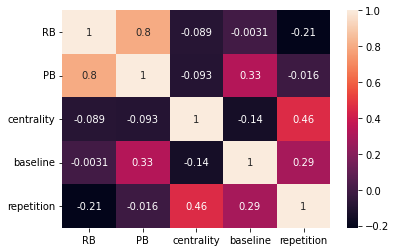

In [58]:
from matplotlib import pyplot as plt
import seaborn as sn

corr_matrix = prediction_comparison_table.corr(method="pearson")
sn.heatmap(corr_matrix, annot=True)
plt.show()
